## Perspective Transform

In this section I shall attempt to find the right perspective transformation for the lane lines.

### Initialisation and previous work

In [38]:
# Set the right working folder to root folder of the project
import os

print("Looking for root folder of the project...")
for folder_depth in range(100): 
    if os.path.exists(".git"):
        root_folder = os.getcwd()
        print("Root folder found. Now working in directory '%s'" % os.getcwd())
        break
    else:
        print("Going up from '%s'" % os.getcwd())
        os.chdir("..")
else:
    raise Exception("Root folder of the project not found. Terminating.")
    

Looking for root folder of the project...
Root folder found. Now working in directory 'D:\Linas\projects\CarND-Advanced-Lane-Lines'


In [39]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from math import ceil


class Plotter:
    def __init__(self, columns, figsize=(20, 40)):
        plt.figure(figsize=figsize)
        
        self.columns = columns
        self.images = []
        
    def add_img(self, img, title):
        assert len(img.shape) == 2 or img.shape[2] == 3
        
        cmap = None
        if len(img.shape) == 2:
            cmap = "gray"
            
        self.images.append((img, title, cmap))
            
    def plot(self):
        j = 1  # Current column
        i = 0
        rows = ceil(len(self.images) // self.columns)
        for img, title, cmap in self.images:
            ax = plt.subplot((rows / self.columns + 1) * self.columns, self.columns, i * self.columns + j)
            ax.set_title(title)
            plt.imshow(img, cmap="gray")
            
            if j % self.columns == 0:
                j = 0
                i += 1
            j += 1


In [40]:
def apply_precomputed_undistortion(img, mtx_filename, dist_filename):
    mtx = np.load(mtx_filename)
    dist = np.load(dist_filename)
    undist_img = cv2.undistort(img, mtx, dist)
    return undist_img


def threshold_image(img):
    # Saturation-based thresholding
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:, :, 2]
    
    s_thresh_value = 150
    s_thresh = np.zeros_like(s_channel)
    s_thresh[s_channel > s_thresh_value] = 1
    
    # Edge Detection
    red = img[:, :, 0]
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combinations
    mag_and_dir = cv2.bitwise_and(mag_thresh, dir_thresh)    
    grad_or_color = cv2.bitwise_or(mag_and_dir, s_thresh)
    
    return grad_or_color

#### Line detection

This section concerns detection of the lines that shall be used to pick points for perspective transform.

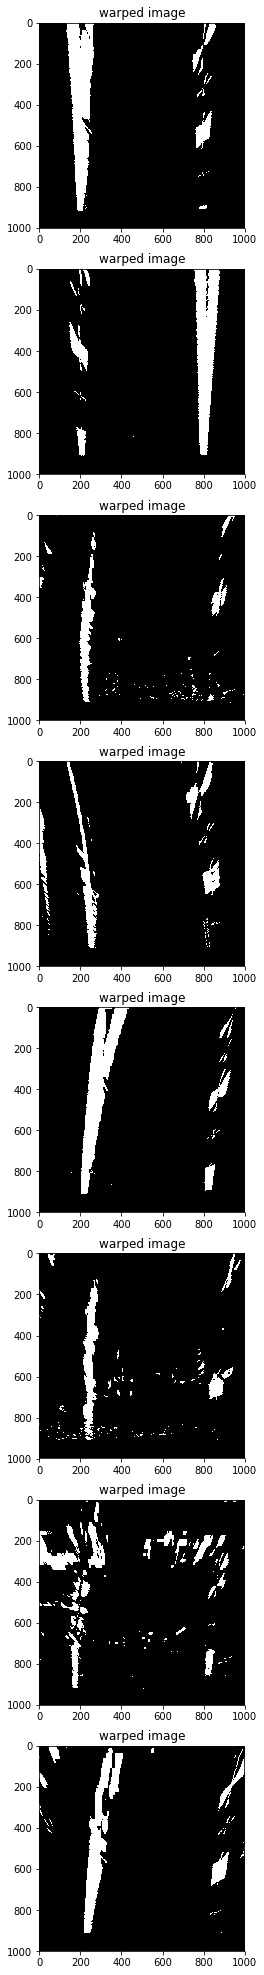

In [41]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=1, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    # Threshold image
    img = threshold_image(img)
    
    # Detect Lines
    # Luckily, the camera resolution is 1280 x 720 in all iamges / videos we're given. This means I can hardode the values.
    top_left  = [578,  463]
    top_right = [706,  463]
    bot_right = [1043, 677]
    bot_left  = [267,  677]
    src_corners = np.float32([top_left, top_right, bot_right, bot_left])
    
    line_img = np.zeros((1000, 1000), dtype=np.uint8)
    
    x_offset = 200
    y_offset = 100
    new_top_left  = [x_offset, y_offset]
    new_top_right = [line_img.shape[1] - x_offset, y_offset]
    new_bot_right = [line_img.shape[1] - x_offset, line_img.shape[0] - y_offset]
    new_bot_left  = [x_offset, line_img.shape[0] - y_offset]
    dst_corners = np.float32([new_top_left, new_top_right, new_bot_right, new_bot_left])
    
    transform_matrix = cv2.getPerspectiveTransform(src_corners, dst_corners)
    warped = cv2.warpPerspective(img, transform_matrix, line_img.shape[::-1], flags=cv2.INTER_LINEAR)

    plotter.add_img(warped, "warped image")
    
plotter.plot()


It is evident that I could have tuned the thresholding based on the images that are already transformed. I will do that later on, when I code up the remaining sections.

#### Application

In [44]:
def warp_perspective(img, x_offset=200, y_offset=100, new_image_shape=(1000, 1000)):
    # Detect Lines
    # Luckily, the camera resolution is 1280 x 720 in all iamges / videos we're given. This means I can hardode the values.
    top_left  = [578,  463]
    top_right = [706,  463]
    bot_right = [1043, 677]
    bot_left  = [267,  677]
    src_corners = np.float32([top_left, top_right, bot_right, bot_left])
    
    line_img = np.zeros(new_image_shape, dtype=np.uint8)
    
    new_top_left  = [x_offset, y_offset]
    new_top_right = [line_img.shape[1] - x_offset, y_offset]
    new_bot_right = [line_img.shape[1] - x_offset, line_img.shape[0] - y_offset]
    new_bot_left  = [x_offset, line_img.shape[0] - y_offset]
    dst_corners = np.float32([new_top_left, new_top_right, new_bot_right, new_bot_left])
    
    transform_matrix = cv2.getPerspectiveTransform(src_corners, dst_corners)
    warped = cv2.warpPerspective(img, transform_matrix, line_img.shape[::-1], flags=cv2.INTER_LINEAR)

    return warped


def process_img(img):
    """
    The preprocessing function, containingcurrent and all previously developed steps
    """
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    img = threshold_image(img)
    
    img = warp_perspective(img, x_offset=200, y_offset=100, new_image_shape=(1000, 1000))
    
    return img